reference: http://haythamfayek.com/2016/04/21/speech-processing-for-machine-learning.html

# Speech Processing for Machine Learning: Filter banks, Mel-Frequency Cepstral Coefficients (MFCCs) and What's In-Between

Speech processing plays an important role in any speech system whether its Automatic Speech Recognition (ASR) or speaker recognition or something else. Mel-Frequency Cepstral Coefficients (MFCCs) were very popular features for a long time; but more recently, filter banks are becoming increasingly popular. In this post, I will discuss filter banks and MFCCs and why are filter banks becoming increasingly popular.

Computing filter banks and MFCCs involve somewhat the same procedure, where in both cases filter banks are computed and with a few more extra steps MFCCs can be obtained. In a nutshell, a signal goes through a pre-emphasis filter; then gets sliced into (overlapping) frames and a window function is applied to each frame; afterwards, we do a Fourier transform on each frame (or more specifically a Short-Time Fourier Transform) and calculate the power spectrum; and subsequently compute the filter banks. To obtain MFCCs, a Discrete Cosine Transform (DCT) is applied to the filter banks retaining a number of the resulting coefficients while the rest are discarded. A final step in both cases, is mean normalization.

# Setup

For this post, I used a 16-bit PCM wav file from here, called “OSR_us_000_0010_8k.wav”, which has a sampling frequency of 8000 Hz. The wav file is a clean speech signal comprising a single voice uttering some sentences with some pauses in-between. For simplicity, I used the first 3.5 seconds of the signal which corresponds roughly to the first sentence in the wav file.

I’ll be using Python 2.7.x, NumPy and SciPy. Some of the code used in this post is based on code available in this repository. https://github.com/jameslyons/python_speech_features

In [1]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import numpy as np
from pylab import *
import scipy.io.wavfile
from scipy.fftpack import dct

In [3]:
sample_rate, signal = scipy.io.wavfile.read('./data/OSR_us_000_0010_8k.wav')  # File assumed to be in the same directory
signal = signal[0:int(3.5 * sample_rate)]  # Keep the first 3.5 seconds

In [4]:
print("signal type: {}".format(type(signal)))
print("signal: {}".format(signal))
print("signal length: {}".format(len(signal)))

print("sample_rate type: {}".format(type(sample_rate)))
print("sample_rate: {}".format(sample_rate))

signal type: <class 'numpy.ndarray'>
signal: [ -919 -1314 -1049 ...   148   136   120]
signal length: 28000
sample_rate type: <class 'int'>
sample_rate: 8000


The raw signal has the following form in the time domain:

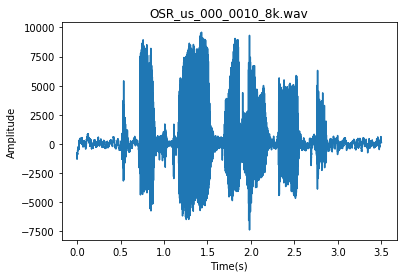

In [5]:
x_time=np.linspace(0, len(signal)/sample_rate, num=len(signal))
plt.title('OSR_us_000_0010_8k.wav')
plt.xlabel('Time(s)')
plt.ylabel('Amplitude')
plt.plot(x_time, signal)

# Pre-Emphasis

The first step is to apply a pre-emphasis filter on the signal to amplify the high frequencies. A pre-emphasis filter is useful in several ways: (1) balance the frequency spectrum since high frequencies usually have smaller magnitudes compared to lower frequencies, (2) avoid numerical problems during the Fourier transform operation and (3) may also improve the Signal-to-Noise Ratio (SNR).

The pre-emphasis filter can be applied to a signal $x$ using the first order filter in the following equation:

$y(t)=x(t)-ax(t-1)$

which can be easily implemented using the following line, where typical values for the filter coefficient ($a$) are 0.95 or 0.97, pre_emphasis = 0.97:

In [6]:
pre_emphasis = 0.97

In [7]:
emphasized_signal = np.append(signal[0], signal[1:] - pre_emphasis * signal[:-1])

Pre-emphasis has a modest effect in modern systems, mainly because most of the motivations for the pre-emphasis filter can be achieved using mean normalization (discussed later in this post) except for avoiding the Fourier transform numerical issues which should not be a problem in modern FFT implementations.

The signal after pre-emphasis has the following form in the time domain:

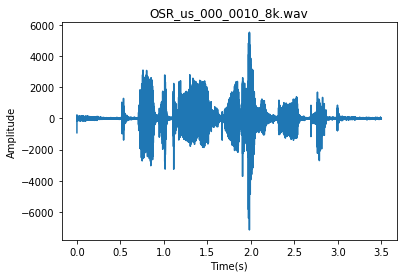

In [8]:
x_time=np.linspace(0, len(signal)/sample_rate, num=len(signal))
plt.title('OSR_us_000_0010_8k.wav')
plt.xlabel('Time(s)')
plt.ylabel('Amplitude')
plt.plot(x_time,emphasized_signal)

# Framing

After pre-emphasis, we need to split the signal into short-time frames. The rationale behind this step is that frequencies in a signal change over time, so in most cases it doesn’t make sense to do the Fourier transform across the entire signal in that we would loose the frequency contours of the signal over time. To avoid that, we can safely assume that frequencies in a signal are stationary over a very short period of time. Therefore, by doing a Fourier transform over this short-time frame, we can obtain a good approximation of the frequency contours of the signal by concatenating adjacent frames.

Typical frame sizes in speech processing range from 20 ms to 40 ms with 50% (+/-10%) overlap between consecutive frames. Popular settings are 25 ms for the frame size, frame_size = 0.025 and a 10 ms stride (15 ms overlap), frame_stride = 0.01.

In [9]:
frame_size = 0.025
frame_stride = 0.01

In [10]:
frame_length, frame_step = frame_size * sample_rate, frame_stride * sample_rate  # Convert from seconds to samples
signal_length = len(emphasized_signal)
frame_length = int(round(frame_length))
frame_step = int(round(frame_step))
num_frames = int(np.ceil(float(np.abs(signal_length - frame_length)) / frame_step))  # Make sure that we have at least 1 frame

pad_signal_length = num_frames * frame_step + frame_length
z = np.zeros((pad_signal_length - signal_length))
pad_signal = np.append(emphasized_signal, z) # Pad Signal to make sure that all frames have equal number of samples without truncating any samples from the original signal

indices = np.tile(np.arange(0, frame_length), (num_frames, 1)) + np.tile(np.arange(0, num_frames * frame_step, frame_step), (frame_length, 1)).T
frames = pad_signal[indices.astype(np.int32, copy=False)]

In [11]:
print("number of frames: {}".format(num_frames))
print(frames)
print(type(frames))
print(frames.shape)

number of frames: 348
[[-9.1900e+02 -4.2257e+02  2.2558e+02 ...  4.9530e+01  1.0324e+02
   4.9510e+01]
 [-4.6220e+01  1.8820e+01 -3.6160e+01 ...  4.1050e+01 -2.4020e+01
  -1.9070e+01]
 [ 1.5450e+01 -2.7830e+01 -2.3430e+01 ... -2.4500e+00  8.7220e+01
   7.6590e+01]
 ...
 [-2.4600e+00  3.3450e+01  2.5440e+01 ...  2.8500e+00 -4.6700e+01
  -3.5750e+01]
 [-2.4380e+01 -1.0340e+01 -2.8850e+01 ...  4.9300e+01  1.8590e+01
   2.8920e+01]
 [-1.7540e+01 -5.0500e+00  4.8300e+00 ...  4.8000e-01  2.5120e+01
  -1.3490e+01]]
<class 'numpy.ndarray'>
(348, 200)


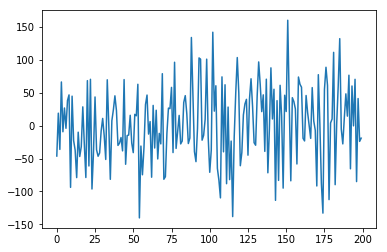

In [12]:
plt.plot(frames[1,:])

# Window

After slicing the signal into frames, we apply a window function such as the Hamming window to each frame. A Hamming window has the following form:

$w[n]=0.54-0.46\cos(\frac{2 \pi n}{N-1})$

where, $0 \leq n \leq N-1$, $N$ is the window length. Plotting the previous equation yields the following plot:

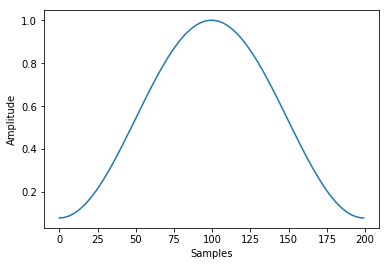

In [13]:
x_axis=np.ones(200)
#print(np.hamming(len(x_axis)))
plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.plot(np.hamming(len(x_axis)))

There are several reasons why we need to apply a window function to the frames, notably to counteract the assumption made by the FFT that the data is infinite and to reduce spectral leakage.

In [14]:
frames *= np.hamming(frame_length)
# frames *= 0.54 - 0.46 * numpy.cos((2 * numpy.pi * n) / (frame_length - 1))  # Explicit Implementation **

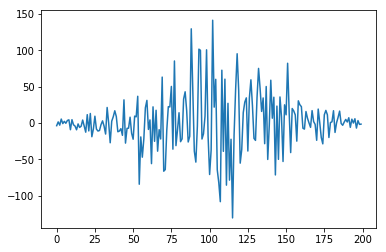

In [15]:
plt.plot(frames[1,:])

# Fourier-Transform and Power Spectrum
We can now do an $N$-point FFT on each frame to calculate the frequency spectrum, which is also called Short-Time Fourier-Transform (STFT), where $N$ is typically 256 or 512, NFFT = 512; and then compute the power spectrum (periodogram) using the following equation:

$P=\frac{{\|FFT(x_i)\|}^2}{N}$

where, ${x}_{i}$ is the ${i}^{th}$ frame of signal $x$. This could be implemented with the following lines:

In [16]:
NFFT = 512

In [17]:
mag_frames = np.absolute(np.fft.rfft(frames, NFFT))  # Magnitude of the FFT
pow_frames = ((1.0 / NFFT) * ((mag_frames) ** 2))  # Power Spectrum

In [18]:
print(type(mag_frames))
print(mag_frames)
print(mag_frames.shape)

<class 'numpy.ndarray'>
[[1138.95074261 1018.27179831  701.47008703 ...  286.23953179
   236.23625947  157.59080684]
 [ 301.25604187  455.94294238  592.03680556 ...  704.4264451
   456.2203675   363.59389398]
 [ 964.69351018  867.232367    632.62753572 ...  665.61099034
   175.44742442   70.46079115]
 ...
 [  64.5637543   296.07037206  442.16077968 ...  120.60563936
   173.27325557  198.59700194]
 [ 642.90106777  621.21041919  557.79197312 ...  161.20329944
   206.41562322  222.81716603]
 [ 369.60424776  522.52516616  657.21828814 ...   72.50441898
    34.12526618    1.96654885]]
(348, 257)


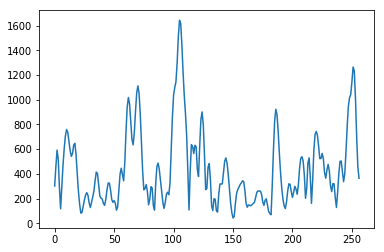

In [19]:
plt.plot(mag_frames[1,:])

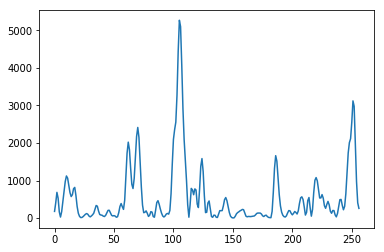

In [20]:
plt.plot(pow_frames[1,:])

# Filter Banks
The final step to computing filter banks is applying triangular filters, typically 40 filters, nfilt = 40 on a Mel-scale to the power spectrum to extract frequency bands. The Mel-scale aims to mimic the non-linear human ear perception of sound, by being more discriminative at lower frequencies and less discriminative at higher frequencies. We can convert between Hertz ($f$) and Mel ($m$) using the following equations:

$m=2595\log{10}{1+\frac{f}{700}}$

$f = 700({10}^{\frac{m}{2595}}-1)$

Each filter in the filter bank is triangular having a response of 1 at the center frequency and decrease linearly towards 0 till it reaches the center frequencies of the two adjacent filters where the response is 0, as shown in this figure:

In [21]:
nfilt = 40

In [22]:
low_freq_mel = 0
high_freq_mel = (2595 * np.log10(1 + (sample_rate / 2) / 700))  # Convert Hz to Mel
mel_points = np.linspace(low_freq_mel, high_freq_mel, nfilt + 2)  # Equally spaced in Mel scale
hz_points = (700 * (10**(mel_points / 2595) - 1))  # Convert Mel to Hz
bin = np.floor((NFFT + 1) * hz_points / sample_rate)

fbank = np.zeros((nfilt, int(np.floor(NFFT / 2 + 1))))
for m in range(1, nfilt + 1):
    f_m_minus = int(bin[m - 1])   # left
    f_m = int(bin[m])             # center
    f_m_plus = int(bin[m + 1])    # right

    for k in range(f_m_minus, f_m):
        fbank[m - 1, k] = (k - bin[m - 1]) / (bin[m] - bin[m - 1])
    for k in range(f_m, f_m_plus):
        fbank[m - 1, k] = (bin[m + 1] - k) / (bin[m + 1] - bin[m])
filter_banks = np.dot(pow_frames, fbank.T)
filter_banks = np.where(filter_banks == 0, np.finfo(float).eps, filter_banks)  # Numerical Stability
filter_banks = 20 * np.log10(filter_banks)  # dB

In [23]:
print(fbank)
print(fbank.shape)
print(fbank.T.shape)
print(filter_banks)
print(filter_banks.shape)
print(filter_banks.T)

[[0.         0.5        1.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.14285714 0.07142857 0.        ]]
(40, 257)
(257, 40)
[[66.48355744 54.76011962 49.63745583 ... 78.64450774 71.99949403
  78.99093178]
 [61.23301363 52.91608023 56.99083717 ... 75.83417962 73.71506105
  80.62107791]
 [64.4089059  48.14534052 45.0122096  ... 82.7346298  80.16663478
  81.85881309]
 ...
 [56.46334726 57.08500675 57.69191529 ... 56.13286897 51.92495349
  47.55649573]
 [61.64337067 57.71358112 64.34304082 ... 50.58091266 51.48988482
  47.66323684]
 [63.19550752 57.6644685  62.88928695 ... 50.50725165 51.30869935
  43.61620137]]
(348, 40)
[[66.48355744 61.23301363 64.40890

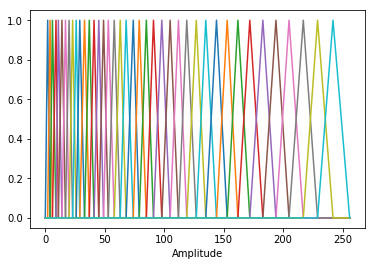

In [24]:
plt.xlabel('Amplitude')
for i in range(fbank.shape[0]):
    plt.plot(fbank[i])

This can be modeled by the following equation (taken from here):

$
H_{m}(k)=
  \begin{cases}
    0 & k<f(m-1)\\
    \frac{k-f(m-1)}{f(m)-f(m-1)} & f(m-1)\leq k < f(m)\\
    1 & k=f(m)\\
    \frac{f(m+1)-k}{f(m+1)-f(m)} & f(m) < k \leq f(m+1)\\
    0 & k > f(m-1)
  \end{cases}
$

After applying the filter bank to the power spectrum (periodogram) of the signal, we obtain the following spectrogram:

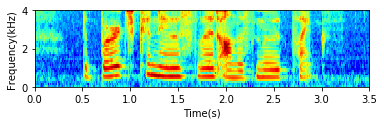

In [25]:
plt.xlabel('Time(s)')
plt.ylabel('Frequency(kHz)')
plt.imshow(np.flipud(filter_banks.T), cmap=plt.cm.jet, aspect=0.2, extent=[0,3.5,0,4.0])

If the Mel-scaled filter banks were the desired features then we can skip to mean normalization.

# Mel-frequency Cepstral Coefficients (MFCCs)
It turns out that filter bank coefficients computed in the previous step are highly correlated, which could be problematic in some machine learning algorithms. Therefore, we can apply Discrete Cosine Transform (DCT) to decorrelate the filter bank coefficients and yield a compressed representation of the filter banks. Typically, for Automatic Speech Recognition (ASR), the resulting cepstral coefficients 2-13 are retained and the rest are discarded; num_ceps = 12. The reasons for discarding the other coefficients is that they represent fast changes in the filter bank coefficients and these fine details don’t contribute to Automatic Speech Recognition (ASR).

In [26]:
num_ceps = 12

In [27]:
mfcc = dct(filter_banks, type=2, axis=1, norm='ortho')[:, 1 : (num_ceps + 1)] # Keep 2-13

In [28]:
print("dimension of dct={}".format(dct(filter_banks, type=2, axis=1, norm='ortho').shape))

dimension of dct=(348, 40)


One may apply sinusoidal liftering1 to the MFCCs to de-emphasize higher MFCCs which has been claimed to improve speech recognition in noisy signals.

In [29]:
cep_lifter = 22

In [30]:
(nframes, ncoeff) = mfcc.shape
n = np.arange(ncoeff)
lift = 1 + (cep_lifter / 2) * np.sin(np.pi * n / cep_lifter)
mfcc *= lift  #*

In [31]:
print(mfcc.shape)
print(mfcc)

(348, 12)
[[ -47.56789461    9.49977234   19.33609685 ... -162.50558754
     4.49872983  129.17775681]
 [ -36.43134752   -3.56248835   73.40163695 ... -211.17528234
  -205.83237932  167.4228818 ]
 [ -59.65984612   15.12060036   67.18448276 ...  -71.14042827
    -4.28524554  241.24363063]
 ...
 [   8.4146385    48.31096582   34.31484928 ...  -97.44844087
   -57.6225855  -203.1607774 ]
 [  16.47984673   58.57224423   42.59394182 ...  -94.22412689
   -49.72948276  -79.83489886]
 [   4.44331939   88.74847636   76.60722124 ... -124.56625781
   135.82064445   71.29245139]]


The resulting MFCCs:

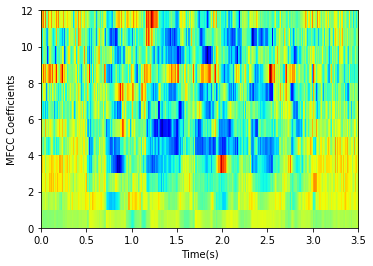

In [32]:
plt.xlabel('Time(s)')
plt.ylabel('MFCC Coefficients')
plt.imshow(np.flipud(mfcc.T), cmap=plt.cm.jet, aspect=0.2, extent=[0,3.5,0,12])

# Mean Normalization
As previously mentioned, to balance the spectrum and improve the Signal-to-Noise (SNR), we can simply subtract the mean of each coefficient from all frames.

In [33]:
filter_banks -= (np.mean(filter_banks, axis=0) + 1e-8)

The mean-normalized filter banks:

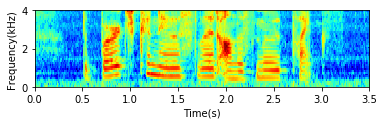

In [34]:
plt.xlabel('Time(s)')
plt.ylabel('Frequency(kHz)')
plt.imshow(np.flipud(filter_banks.T), cmap=plt.cm.jet, aspect=0.2, extent=[0,3.5,0,4.0])

and similarly for MFCCs:

In [35]:
mfcc -= (np.mean(mfcc, axis=0) + 1e-8)

In [36]:
print(mfcc)

[[ -40.33533033    6.27482034   43.1938621  ...  -33.93320469
   138.98679808  158.49102169]
 [ -29.19878324   -6.78744034   97.2594022  ...  -82.60289949
   -71.34431107  196.73614668]
 [ -52.42728184   11.89564837   91.04224801 ...   57.43195458
   130.20282271  270.55689551]
 ...
 [  15.64720279   45.08601383   58.17261452 ...   31.12394198
    76.86548274 -173.84751252]
 [  23.71241102   55.34729223   66.45170706 ...   34.34825596
    84.75858549  -50.52163398]
 [  11.67588367   85.52352437  100.46498648 ...    4.00612504
   270.3087127   100.60571627]]


The mean-normalized MFCCs:

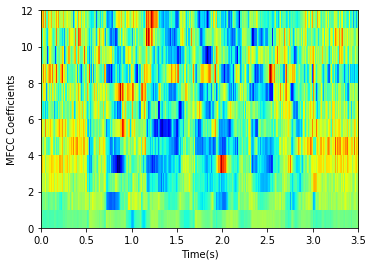

In [37]:
plt.xlabel('Time(s)')
plt.ylabel('MFCC Coefficients')
plt.imshow(np.flipud(mfcc.T), cmap=plt.cm.jet, aspect=0.2, extent=[0,3.5,0,12])

# Filter Banks vs MFCCs
To this point, the steps to compute filter banks and MFCCs were discussed in terms of their motivations and implementations. It is interesting to note that all steps needed to compute filter banks were motivated by the nature of the speech signal and the human perception of such signals. On the contrary, the extra steps needed to compute MFCCs were motivated by the limitation of some machine learning algorithms. The Discrete Cosine Transform (DCT) was needed to decorrelate filter bank coefficients, a process also referred to as whitening. In particular, MFCCs were very popular when Gaussian Mixture Models - Hidden Markov Models (GMMs-HMMs) were very popular and together, MFCCs and GMMs-HMMs co-evolved to be the standard way of doing Automatic Speech Recognition (ASR)2. With the advent of Deep Learning in speech systems, one might question if MFCCs are still the right choice given that deep neural networks are less susceptible to highly correlated input and therefore the Discrete Cosine Transform (DCT) is no longer a necessary step. It is beneficial to note that Discrete Cosine Transform (DCT) is a linear transformation, and therefore undesirable as it discards some information in speech signals which are highly non-linear.

It is sensible to question if the Fourier Transform is a necessary operation. Given that the Fourier Transform itself is also a linear operation, it might be beneficial to ignore it and attempt to learn directly from the signal in the time domain. Indeed, some recent work has already attempted this and positive results were reported. However, the Fourier transform operation is a difficult operation to learn and may arguably increase the amount of data and model complexity needed to achieve the same performance. Moreover, in doing Short-Time Fourier Transform (STFT), we’ve assumed the signal to be stationary within this short time and therefore the linearity of the Fourier transform would not pose a critical problem.

# Conclusion
In this post, we’ve explored the procedure to compute Mel-scaled filter banks and Mel-Frequency Cepstrum Coefficients (MFCCs). The motivations and implementation of each step in the procedure were discussed. We’ve also argued the reasons behind the increasing popularity of filter banks compared to MFCCs.

tl;dr: Use Mel-scaled filter banks if the machine learning algorithm is not susceptible to highly correlated input. Use MFCCs if the machine learning algorithm is susceptible to correlated input.

